### **VGGish installation**

In [27]:
# !pip install -i https://test.pypi.org/simple/ torchvggish

In [28]:
from torchvggish import vggish, vggish_input

# Initialise model and download weights
embedding_model = vggish()
embedding_model.eval()

example = vggish_input.wavfile_to_examples("../../datasets/hand_curated/water/water.wav")
print(example.shape)  # (1, 96, 64)
embeddings = embedding_model.forward(example)
print(embeddings.shape)  # (1, 128)
example = vggish_input.wavfile_to_examples("../../datasets/hand_curated/fire/fire.wav")
print(example.shape)  # (1, 96, 64)
embeddings = embedding_model.forward(example)
print(embeddings.shape)  # (1, 128)

torch.Size([50, 1, 96, 64])
torch.Size([50, 128])
torch.Size([84, 1, 96, 64])
torch.Size([84, 128])


### **Classifier experiment**

In [29]:
import os
import numpy as np
import librosa
import torch
import torchaudio
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import itertools
import soundfile as sf
import resampy
import pickle
from tqdm import tqdm

# Add the parent directory to the Python path
import sys
import os
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import loss function
from texstat.functions import *
import texstat.torch_filterbanks.filterbanks as fb

def vggish_model(segment):
    # input must have sr=16000Hz, dtype=int16 and range in [-1.0, +1.0]
    embeddings = embedding_model.forward(segment)
    embeddings = embeddings.detach().numpy()
    if len(embeddings.shape) > 1:
        print("mírame")
        embeddings = np.mean(embeddings, axis=0)
    return embeddings

def load_audio_embeddings(folder_path, model_function, sample_rate=16000, segment_size= int(16000 * 2**16/44100), num_segments=20):
    """
    Load audio embeddings for training.

    Args:
        folder_path (str): Path to dataset with subfolders for each class.
        model_function (callable): Function to extract embeddings (must accept a raw audio segment).
        segment_size (int, optional): Size of the audio segment to extract. Defaults to 2**16.
        num_segments (int, optional): Number of segments per class. Defaults to 20.
        *args: Positional arguments to pass to model_function.
        **kwargs: Keyword arguments to pass to model_function.

    Returns:
        np.ndarray: Feature matrix (X).
        np.ndarray: One-hot encoded labels (y).
        dict: Mapping of class indices to class names.
    """

    X, y = [], []
    class_labels = {}

    # number_of_classes = len(os.listdir(folder_path))
    # segments_per_class = num_segments // number_of_classes

    for idx, class_folder in enumerate(sorted(os.listdir(folder_path))):
        class_path = os.path.join(folder_path, class_folder)
        if not os.path.isdir(class_path):
            continue
        
        class_labels[idx] = class_folder

        wav_files = [f for f in os.listdir(class_path) if f.endswith(".wav")]
        if not wav_files:
            continue
        
        print(f"Processing class: {class_folder}")
        for _ in tqdm(range(num_segments), desc="Processing Segments"):
            selected_file = random.choice(wav_files)  # Pick a new random file each time
            # wav_files.remove(selected_file)  # Remove to avoid reselecting the same file
            
            file_path = os.path.join(class_path, selected_file)
            audio, sr = sf.read(file_path, dtype='int16')
            # print(f"File: {file_path}")
            # print(f"Audio shape: {audio.shape}")
            # print(f"Audio dtype: {audio.dtype}")
            # print(f"Sample rate: {sr}")
            # Convert to mono if the audio has more than one channel
            if len(audio.shape) > 1:
                audio = np.mean(audio, axis=1)
            # Resample to 16 kHz if the sample rate is not already 16 kHz
            target_sample_rate = sample_rate
            if sr != target_sample_rate:
                audio = resampy.resample(audio, sr, target_sample_rate)
                sr = target_sample_rate  # Update the sample rate to 16000
            # Normalize
            audio = audio / 32768.0 
            # Ensure it is long enough
            total_samples = len(audio)
            if total_samples < segment_size:
                num_repeats = (segment_size // total_samples) + 1  # Compute required repeats
                hann_window = np.hanning(total_samples)  # Create a smooth window
                audio_repeated = np.zeros(num_repeats * total_samples)
                # Apply overlap-add with windowing
                for i in range(num_repeats):
                    start_idx = i * total_samples // 2  # 50% overlap
                    audio_repeated[start_idx:start_idx + total_samples] += audio * hann_window
                audio = audio_repeated
                total_samples = len(audio)
            # Make random segment
            start = random.randint(0, total_samples - segment_size)
            segment = audio[start:start + segment_size]

            #Transform to be used with the model
            segment = vggish_input.waveform_to_examples(segment, sr, True)

            # Generate embedding and store it
            embedding = model_function(segment)

            # If there is a NaN in the embedding, skip this segment
            if np.isnan(embedding).any():
                continue
            X.append(embedding)
            y.append(idx)

    X = np.array(X).reshape(-1, 128)
    y = np.array(y).reshape(-1, 1)
    encoder = OneHotEncoder(sparse_output=False)
    y = encoder.fit_transform(y)

    return X, y, class_labels

def train_and_evaluate_mlp(X, y, class_labels, test_size=0.3, random_seed=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)
    
    classifier = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000, solver='adam')
    classifier.fit(X_train, np.argmax(y_train, axis=1))
    
    y_pred = classifier.predict(X_test)
    y_test_labels = np.argmax(y_test, axis=1)
    
    # Accuracy
    print("Accuracy:", accuracy_score(y_test_labels, y_pred))
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test_labels, y_pred, target_names=[class_labels[i] for i in class_labels]))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_labels, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    # Extract class names as a list
    class_names = [class_labels[i] for i in range(len(class_labels))]

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]), horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return classifier


### **1. TexStat Classification**

### **1.1. Hand-curated dataset**

Accuracy: 0.9833333333333333
Classification Report:
              precision    recall  f1-score   support

     bubbles       1.00      1.00      1.00        38
        fire       1.00      0.90      0.95        31
    keyboard       1.00      1.00      1.00        29
        rain       1.00      1.00      1.00        24
       water       1.00      1.00      1.00        25
        wind       0.92      1.00      0.96        33

    accuracy                           0.98       180
   macro avg       0.99      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180

Confusion Matrix:
[[38  0  0  0  0  0]
 [ 0 28  0  0  0  3]
 [ 0  0 29  0  0  0]
 [ 0  0  0 24  0  0]
 [ 0  0  0  0 25  0]
 [ 0  0  0  0  0 33]]


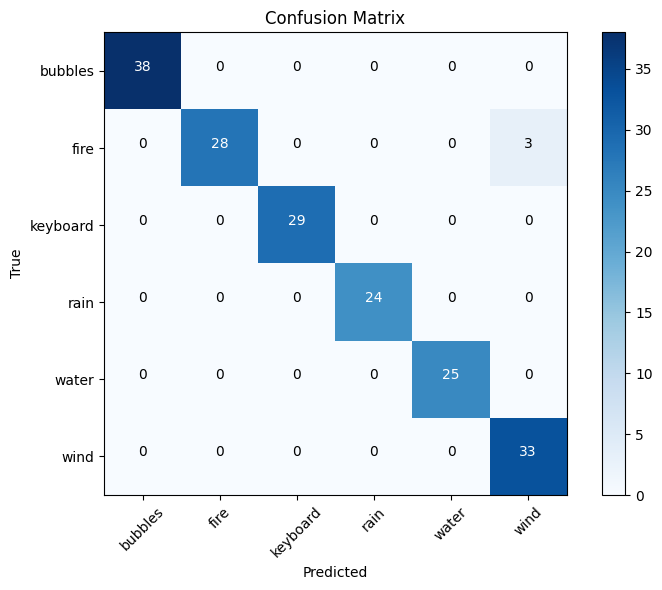

MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000)

In [30]:
# # Stats parameters
# sr            = 16000
# frame_size    = int(16000 * 2**16/44100)

# # Embeddings computation for dataset
# X, y, class_labels = load_audio_embeddings(
#     folder_path="../../datasets/hand_curated/",
#     model_function=vggish_model,
#     sample_rate =sr,
#     segment_size=frame_size, 
#     num_segments=100
# )

# embeddings_dict = {}
# embeddings_dict['X'] = X
# embeddings_dict['y'] = y
# embeddings_dict['class_labels'] = class_labels

# # Pickle save the embeddings
# with open('hand_curated_dataset_vggish.pkl', 'wb') as f:
#     pickle.dump(embeddings_dict, f)

# Load the embeddings from the pickle file
with open('hand_curated_dataset_vggish.pkl', 'rb') as f:
    embeddings_dict = pickle.load(f)

X= embeddings_dict['X']
y= embeddings_dict['y']
class_labels= embeddings_dict['class_labels']

train_and_evaluate_mlp(X, y, class_labels, test_size=0.3, random_seed=42)

### **1.2. Boreillysegmented16K_small dataset**

Accuracy: 0.7133333333333334
Classification Report:
              precision    recall  f1-score   support

         arp       0.91      0.83      0.87        35
      braids       0.29      0.50      0.36        20
      briads       0.62      0.57      0.59        37
          em       0.86      0.56      0.68        34
        ichT       0.88      0.92      0.90        24
        moog       0.65      0.45      0.54        33
      nether       0.52      0.73      0.61        30
     reaktor       0.86      0.78      0.82        23
         skr       0.88      0.79      0.84        29
     stochos       0.88      1.00      0.93        35

    accuracy                           0.71       300
   macro avg       0.73      0.71      0.71       300
weighted avg       0.75      0.71      0.72       300

Confusion Matrix:
[[29  0  0  0  0  2  2  0  0  2]
 [ 0 10  8  0  0  1  1  0  0  0]
 [ 2 10 21  1  0  3  0  0  0  0]
 [ 0  4  1 19  3  2  4  0  1  0]
 [ 0  1  0  1 22  0  0  0  0  0]
 [ 1  

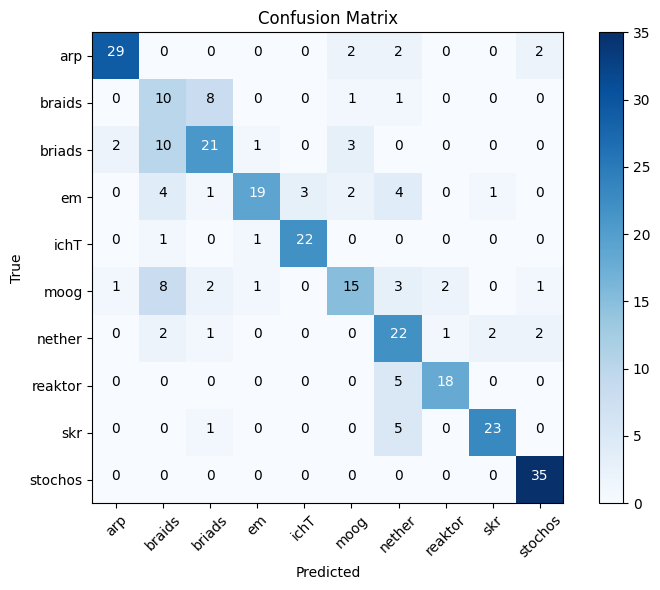

MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000)

In [32]:
# # Stats parameters
# sr            = 16000
# frame_size    = int(16000 * 2**16/44100)

# # Embeddings computation for dataset
# X, y, class_labels = load_audio_embeddings(
#     folder_path="../../datasets/boreillysegmented16K_small/",
#     model_function=vggish_model,
#     sample_rate =sr,
#     segment_size=frame_size, 
#     num_segments=100
# )

# embeddings_dict = {}
# embeddings_dict['X'] = X
# embeddings_dict['y'] = y
# embeddings_dict['class_labels'] = class_labels

# # Pickle save the embeddings
# with open('boreillysegmented16K_small_dataset_vggish.pkl', 'wb') as f:
#     pickle.dump(embeddings_dict, f)

# Load the embeddings from the pickle file
with open('boreillysegmented16K_small_dataset_vggish.pkl', 'rb') as f:
    embeddings_dict = pickle.load(f)

X= embeddings_dict['X']
y= embeddings_dict['y']
class_labels= embeddings_dict['class_labels']

train_and_evaluate_mlp(X, y, class_labels, test_size=0.3, random_seed=42)

### **1.4. Syntex dataset**

Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

    applause       0.97      0.95      0.96        38
        chua       0.97      0.97      0.97        31
     peepers       0.94      1.00      0.97        29
        pops       0.85      0.92      0.88        24
     tapping       0.95      0.84      0.89        25
        wind       1.00      1.00      1.00        33

    accuracy                           0.95       180
   macro avg       0.95      0.95      0.94       180
weighted avg       0.95      0.95      0.95       180

Confusion Matrix:
[[36  0  1  1  0  0]
 [ 0 30  1  0  0  0]
 [ 0  0 29  0  0  0]
 [ 1  0  0 22  1  0]
 [ 0  1  0  3 21  0]
 [ 0  0  0  0  0 33]]


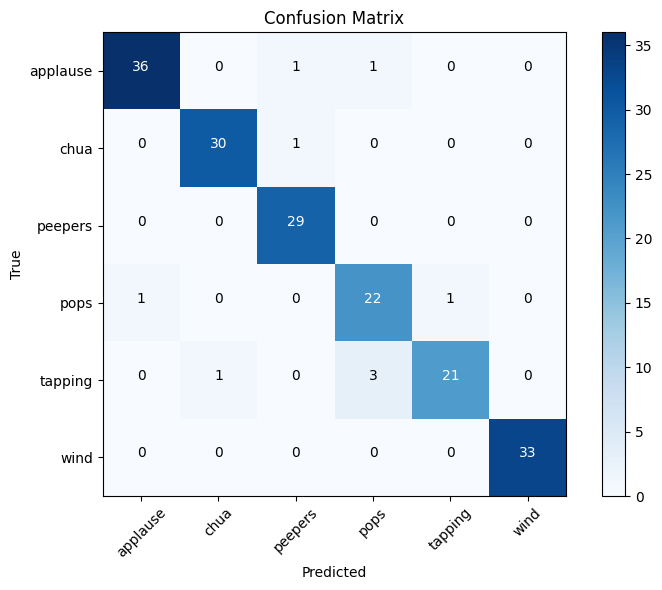

MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000)

In [33]:
# # Stats parameters
# sr            = 16000
# frame_size    = int(16000 * 2**16/44100)

# # Embeddings computation for dataset
# X, y, class_labels = load_audio_embeddings(
#     folder_path="../../datasets/syntex_dataset/",
#     model_function=vggish_model,
#     sample_rate =sr,
#     segment_size=frame_size, 
#     num_segments=100
# )

# embeddings_dict = {}
# embeddings_dict['X'] = X
# embeddings_dict['y'] = y
# embeddings_dict['class_labels'] = class_labels

# # Pickle save the embeddings
# with open('syntex_dataset_vggish.pkl', 'wb') as f:
#     pickle.dump(embeddings_dict, f)

# Load the embeddings from the pickle file
with open('syntex_dataset_vggish.pkl', 'rb') as f:
    embeddings_dict = pickle.load(f)

X= embeddings_dict['X']
y= embeddings_dict['y']
class_labels= embeddings_dict['class_labels']

train_and_evaluate_mlp(X, y, class_labels, test_size=0.3, random_seed=42)